# Scenario 5: Modelling in COPASI
In this notebook we demonstrate how to open an EnzymeML document, and use [basico](https://basico.readthedocs.io), a high level interface to [COPASI](http://copasi.org) to assign a kinetic function to the model, and estimate it's parameters based on the measurement data included in the EnzymeML document. From there we start two modeling project, one based on ODE's and one based on mass action kinetics to demonstrate how that could be done. 

For this to work, you will have to have basico installed, as well as PyEnzymeML, which you can do by running: 

```
    !pip install copasi-basico    
```

We also need a newer version of PyEnzymeML that has not yet been released, so will have to be installed directly from git, using: 

```
    !pip install git+git://github.com/EnzymeML/PyEnzyme.git@feature/experiment-class
```


After that we start with our imports:

In [1]:
import os
from basico import *
from pyenzyme.enzymeml.core import *
from pyenzyme.enzymeml.models import KineticModel

In [2]:
%matplotlib inline

## Modeling the reaction encoded in the EnzymeML document
Here we use the EnzymeML document prepared for the Lagerman 2021 paper: “Kinetic model development for α-amino ester hydrolase (AEH)-catalyzed synthesis of β-lactam antibiotics”  https://doi.org/10.1016/j.cej.2021.131816 

We do this in several ways, 
* first we demonstrate how to just fit a simple trajectory using COPASI. This can be readily compared to the cases where ODE modeling was being used, as for example in the use case described by Hannah Dienhart.  
* second we show how to enter the same ODE's from the Lagerman publication and look at fitting those to the experimental data
* third we show how to create a full model from scratch as Mass action kinetics and use those to fir the data. 

In [3]:
# First read the EnzymeML document that has been created
enzmldoc = EnzymeMLDocument.fromFile('./data/EnzymeML_Lagerman.omex')
enzmldoc

EnzymeML_Lagerman
>>> Reactants
	ID: s0 	 Name: (R)-(-)-2-Phenylglycine methyl ester
	ID: s1 	 Name: 7-Aminodesacetoxycephalosporanic acid
	ID: s2 	 Name: Cephalexin
	ID: s3 	 Name: Phenylglycine
>>> Proteins
	ID: p0 	 Name: Amino Ester Hydrolase
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Cephalexin synthesis

we begin by extracting the measurement data for a given time course to fit: 

In [4]:
reaction_id = 'r0'
reaction = enzmldoc.getReaction(reaction_id)
reactant_id = 's0'
measurement_id = 'm0'

m = enzmldoc.getMeasurement(measurement_id)
data = m.getReactant(reactant_id).replicates[0].data

to use this data for COPASI, we will form it into a data frame, using the names for `Time` to denote that the index is time, and `[PGME]` to denote the transient concentrations of PGME. That way the data is automatically mapped later on:

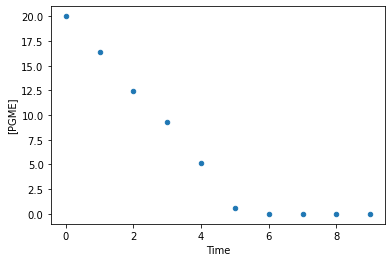

In [5]:
exp_1 = pd.DataFrame(data=data, columns=['[PGME]'])
exp_1.index.name='Time'
exp_1 = exp_1.reset_index()
exp_1.plot.scatter(x='Time', y='[PGME]');

now we load the model into COPASI: 

In [6]:
load_model_from_string(enzmldoc.toXMLString());

In [7]:
get_species()[['initial_concentration']]

,initial_concentration
name,
(R)-(-)-2-Phenylglycine methyl ester,20.0
7-Aminodesacetoxycephalosporanic acid,42.0
Cephalexin,1.0
Phenylglycine,1.0
Amino Ester Hydrolase,0.2


for simplicities sake, i will rename the elements to something shorter, and set some initial concetration for the two species that had none: 

In [8]:
set_species('(R)-(-)-2-Phenylglycine methyl ester', new_name='PGME')
set_species('7-Aminodesacetoxycephalosporanic acid', new_name='7ADAC')
set_species('Cephalexin', new_name='CEX', initial_concentration=0)
set_species('Phenylglycine', new_name='PG', initial_concentration=0)
set_species('Amino Ester Hydrolase', new_name='AEH')

In [9]:
get_species()[['initial_concentration']]

,initial_concentration
name,
PGME,20.0
7ADAC,42.0
CEX,0.0
PG,0.0
AEH,0.2


now lets have a look at the reaction, where we will see that there is no kinetic function mapped to the element yet. 

In [10]:
get_reactions()[['scheme', 'function']]

,scheme,function
name,,
Cephalexin synthesis,PGME + 7ADAC = CEX + PG; AEH,undefined


at this point we could use one of the inbuilt functions from the COPASI Function Database, the only applicable ones right now would be: 

* Mass action (reversible)
* Ordered Bi Bi
* Ping Pong Bi Bi

In [11]:
set_reaction('Cephalexin synthesis', function='Mass action (reversible)')

And at this point we are ready to simulate the model: 

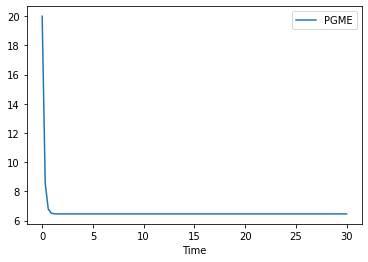

In [12]:
run_time_course(duration=30)[['PGME']].plot();

COPASI, normally would not allow to use Michaelis Menten kinetics for this reaction, as there are 2 substrates and 2 products defined, and the normal scheme of $$ \frac{V_{max} \cdot S}{k_m + S} $$ deals only with one substrate. So i define a general function here, that by passes this check, so that the result is comparable with the one from the python implementation by Hannah Dienhart.

Note: in general though, this should not be used, as neither the other substrate, nor the two products appear in the equation, and thus negative concentrations can occur. 

In [13]:
add_function('General Michaelis', infix = 'V * S / (K + S)', mapping = {'S': 'substrate'}, type='general');

In [14]:
# lets use this function mapping 'S' to PGME
set_reaction('Cephalexin synthesis', function='General Michaelis', mapping={'S': 'PGME'})

In [15]:
get_reactions()[['scheme', 'function']]

,scheme,function
name,,
Cephalexin synthesis,PGME + 7ADAC = CEX + PG; AEH,General Michaelis


at this point we change to a working folder, in which files will be saved (the experimental data needs to be saved to file, so it can be used by COPASI: 

In [16]:
os.chdir('./working_dir/')

### Parameter Estimation Setup
Now lets define the parameter estimation setup. We want: 

* both the $ V_{max} $ as well as $ k_m $ fitted here use the `get_fit_item_template` function to just add all local parameters to be estimated. 
* and the experimental data from above to be used, since above we named the columns of the table already with the names required by basico, the mapping of data columns to model elements happens automatically. In general if on 'Time' column is present, the data is assumed to be steady state data, otherwise it will be used as time course data. 

In [17]:
set_fit_parameters(get_fit_item_template(include_local=True))

In [18]:
add_experiment('Experiment 1', exp_1);

Now we are ready to run the parameter estimation using all of the methods implemented in COPASI, we also tell COPASI to write the results back into the model:

In [19]:
run_parameter_estimation(method=PE.LEVENBERG_MARQUARDT, update_model=True)

,lower,upper,sol,affected
name,,,,
(Cephalexin synthesis).V,0.001,1000,3.753631,[]
(Cephalexin synthesis).K,0.001,1000,0.001390,[]


Finally we plot the result of the fit: 

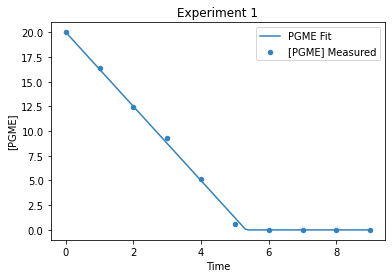

In [20]:
plt = plot_per_experiment();

In [21]:
plt[0][0].savefig('../svgs/scenario5_step1.svg')

This could now be written back into the EnzymeML document, using the smae approach as demonstrated in [Scenario 4](https://github.com/EnzymeML/Publications/blob/main/2021_Lauterbach/Scenario4/InsightIntoMechanismByModelling.ipynb)


## Modeling explicitly through ODEs
Here i begin with a new model, in which the equations from the Lagerman publication are entered: 

$$ \frac{d[PG]}{dt}=([E]/((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k3))((k_2 [PGME])/K_s   +(k_4b [CEX])/K_p )(k_3+(k_5 [7-ADCA])/K_n   +(k_6 [PGME])/K_si ) $$ 

$$  d[CEX]/dt=(k_2 [E][PGME])/K_s -([E]/((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k3))((k_2 [PGME])/K_s   +(k_4b [CEX])/K_p )(k_3+(k_5 [7-ADCA])/K_n ) $$ 

$$ [E]=([E]_0  exp⁡(-k_d t))/(1+[PGME]^2/(K_s K_si )+[7-ADCA]/K_n + ((k_2 [PGME])/(K_s ((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k3) ))(1+[7-ADCA]/K_n +[PGME]/K_si )+[CEX]/K_p +[PG]/K_p2i ) $$

these can be directly added to a new model. But first i start with a couple of utility functions:

In [22]:
def add_assumptions():
    # Mass balance: d[CEX]/dt = - d[7-ADCA]/dt:
    set_species('7-ADCA', status='ode', expression='-1 * ( ' + get_species('CEX').expression[0] + ' )')
    # d[PGME]/dt = -1 * (d[CEX]/dt + d[PG]/dt)
    set_species('PGME', status='ode', expression='-1 * ( ' + get_species('CEX').expression[0] + ' + ' + get_species('PG').expression[0] + ' )')

# this function sets all initial concentrations to 0, except for the ones we know the 
# concentrations for
def set_initial_concentrations():
    for species in get_species().index.to_list(): 
        set_species(species, initial_concentration=0)
    set_species('E0', initial_concentration=0.2, status='fixed')
    set_species('E', initial_concentration=0.0002, status='fixed')
    set_species('PGME', initial_concentration=20)
    set_species('7-ADCA', initial_concentration=40)

# create the parameters we want to estimate: 
def add_parameters_with_values():
    add_parameter('K_s', initial_value=14)
    add_parameter('k_2', initial_value=432)
    add_parameter('K_n', initial_value=290)
    add_parameter('k_3', initial_value=417)
    add_parameter('k_4', initial_value=73600)
    add_parameter('k_5', initial_value=491)
    add_parameter('k_6', initial_value=1660)
    add_parameter('K_si', initial_value=20)
    add_parameter('K_p', initial_value=39)
    add_parameter('k_4b', initial_value=9126)
    add_parameter('k_d', initial_value=6.43e-4)
    add_parameter('K_pg', initial_value=12)

# a function to create all fit parameters 
# for simplicities sake i've alrady converted the enzymeml measurements to 
# a text file that is in this folder: 
def add_parameter_estiation_setup(filename='../data/experiments_colton_1-4.txt'):
    template = get_fit_item_template(include_global=True, default_lb=1e-2, default_ub=1e6)
    to_remove = None
    for d in template:
        # set lower bound for the equilibrium constants        
        if 'Values[K_si' in d['name']:
            d['upper'] = 50
            continue
        if 'Values[K' in d['name']:
            d['upper'] = 1000
            continue
        if 'Values[vr' in d['name']:
            to_remove = d
        if 'Values[k_d' in d['name']:
            d['upper'] = 0.5
            d['lower'] = 0.3            
            
    if to_remove is not None:
        template.remove(d)

    set_fit_parameters(template)
    data = pd.read_csv(filepath_or_buffer=filename, sep='\t')
    nan_rows = data.loc[data['Time'].isna()].index.to_list()
    df_list = []
    last = -1
    for n in nan_rows:
        df_list.append(data.iloc[last + 1:n,:])
        last = n
    df_list.append(data.iloc[last + 1:,:])
    # remove existing ones
    for p in glob.glob('Exp*.txt'): 
        os.remove(p)
    # add new ones
    for i in range(len(df_list)):
        name = f'Experiment_{i}'
        add_experiment(name, df_list[i])

Now lets create the model: 

In [23]:
model4 = new_model(name='Model 4', time_unit='min', volume_unit='ml', quantity_unit='mmol', 
                  notes="""Model 4 (modelled using ODE's)
                  
                  This implements the differential equations directly as given 
                  in the Lagerman_2021 paper. 
                  
                  """)
add_parameters_with_values()

In [24]:
add_equation('d[PG]/dt=([E]/((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k_3))((k_2 [PGME])/K_s   +(k_4b [CEX])/K_p )(k_3+(k_5 [7-ADCA])/K_n   +(k_6 [PGME])/K_si )')
add_equation(
            'd[CEX]/dt=(k_2 [E][PGME])/K_s -([E]/((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k_3))((k_2 [PGME])/K_s   +(k_4b [CEX])/K_p )(k_3+(k_5 [7-ADCA])/K_n )')
add_equation(
            '[E]=([E0] exp(-k_d t))/(1+[PGME]^2/(K_s K_si )+[7-ADCA]/K_n + ((k_2 [PGME])/(K_s ((k_4 [7-ADCA])/K_n +(k_5 [7-ADCA])/K_n +(k_6 [PGME])/K_si +k_3) ))(1+[7-ADCA]/K_n +[PGME]/K_si )+[CEX]/K_p +[PG]/K_pg )')

In [25]:
add_assumptions()
set_initial_concentrations()
add_parameter_estiation_setup()
set_initial_concentrations()

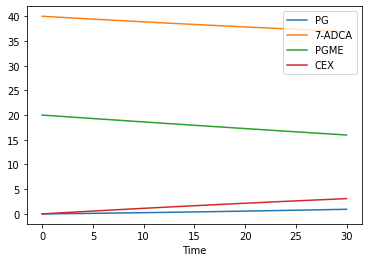

In [26]:
run_time_course(duration=30).plot();

now lets run the parameter estimation, here i just switched to a local method that is unlikely to yield the best result:

In [27]:
run_parameter_estimation(method=PE.LEVENBERG_MARQUARDT, update_model=True)

,lower,upper,sol,affected
name,,,,
Values[K_s],0.01,1000.0,0.623142,[]
Values[k_2],0.01,1000000.0,430.992104,[]
Values[K_n],0.01,1000.0,286.369710,[]
Values[k_3],0.01,1000000.0,410.819718,[]
Values[k_4],0.01,1000000.0,73599.987099,[]
Values[k_5],0.01,1000000.0,486.558809,[]
Values[k_6],0.01,1000000.0,1658.088248,[]
Values[K_si],0.01,50.0,0.187133,[]
Values[K_p],0.01,1000.0,45.086928,[]


utility functions for plotting the results per experiment, or per dependent variable exist. These functions return a list if tuples, that contain the matplotlib figures and the axis. Here,  these are saved in variables, so that the plots can be exported later on as files if needed. 

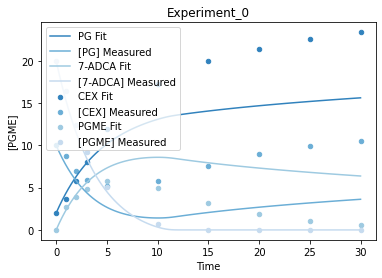

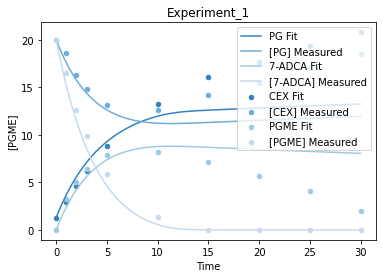

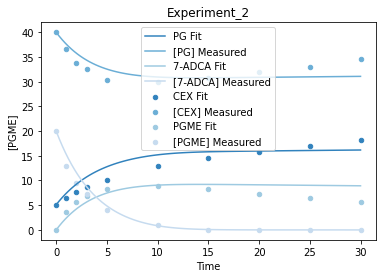

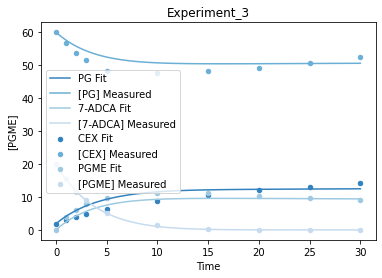

In [28]:
ode_experiment = plot_per_experiment()

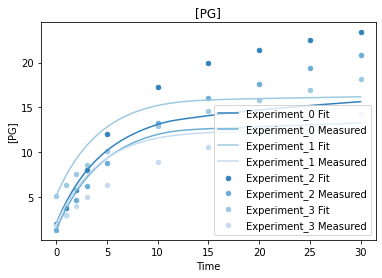

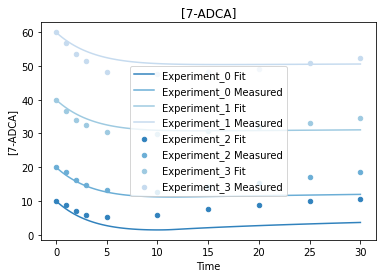

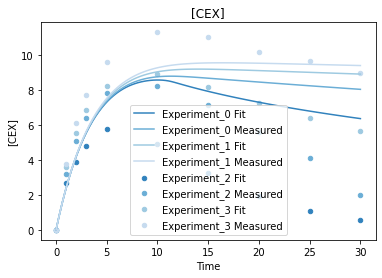

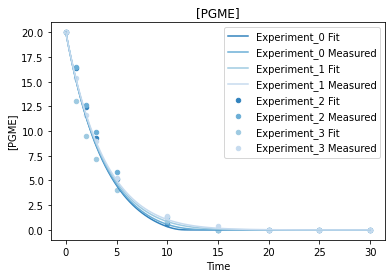

In [29]:
ode_dependent = plot_per_dependent_variable()

### Continuing Analysis
Running parameter estimation with a local method once, does usually not find the best point in parameter space, so at this point we save the model and carry out further analysis in COPASI.  

In order to carry out further analysis in COPASI (or the command line version of COPASI on cluster environments), we mark the parameter estimation task as executable and tell COPASI to randomize start values. That way each run of the parameter estimation searches around a different point in parameter space. Finally we save the model. 

In [30]:
set_task_settings(T.PARAMETER_ESTIMATION, 
                  {
                      'scheduled': True,
                      'problem': {'Randomize Start Values': True},
                      'method': {'name': PE.LEVENBERG_MARQUARDT}
                  })
save_model_and_data(os.path.join(os.getcwd(), 'ode_master.cps'))

Now the model can be run directly with the command line version of COPASI, in cluster environments many times, and the best fit selected. In this notebook we just exemplify this by running it twice the following command line arguments were used:
    
 * `--nologo`: suppresses the output of the COPASI version number
 * `--save result_file_ode*`: we want the final value found after the parameter estimation to be written to a new file, so we can easily retrieve it later. Important is that this file is different for each invocation, so that no parameter set is overwritten. 
 * `--report-file report_ode*`: similarly, we save the report (including the statistics and improvements for each individual run) also to a new file for each invocation
 * the last argument is the COPASI file that we want to run. 


In [31]:
!CopasiSE --nologo --save result_file_ode1.cps --report-file report_ode1.txt ode_master.cps
!CopasiSE --nologo --save result_file_ode2.cps --report-file report_ode2.txt ode_master.cps

Loading the files back into basico, we can access the fit statistic for the files:

In [32]:
def report_fit_for_file(filename): 
    load_model(filename)
    run_parameter_estimation(method=PE.CURRENT_SOLUTION, 
                         settings={'problem': 
                                   {'Randomize Start Values': False},})
    return get_fit_statistic()['obj']

In [33]:
report_fit_for_file(os.path.join(os.getcwd(), 'result_file_ode1.cps'))

674.0126331369094

In [34]:
report_fit_for_file(os.path.join(os.getcwd(), 'result_file_ode2.cps'))

865.5416378467434

As expected the objective value (that describes how well the simulation with the found parameters describe the data), will vary widely between the runs. Repeating this process many times over yields a good fit. 

At this point one would then have a look at whether or not the parameters found have been identifiable. That goes beyond the scope of this notebook, but a good description on how to do this in COPASI is given in: Schaber J (2012) *Easy parameter identifiability analysis with COPASI*. Biosystems 110, 183– 185. 

## Modeling explicitly through a cascade of Mass action kinetics
In the last case, we now want to model the same data, this time through individual reaction steps:  

In [35]:
model = new_model(name='Model 4 (Mass Action)', time_unit='min', volume_unit='ml', quantity_unit='mmol');

Since the paper specifies, that individual steps are described by equilibrium constants, we add new functiosn to COPASI, for the different number of arguments needed: 

In [36]:
add_function('MassAction Keq (2s, 1p)', 'v_r*(K_eq * A * B - C)', mapping={'A': 'substrate', 'B': 'substrate', 'C': 'product'});
add_function('MassAction Keq (1s, 2p)', 'v_r*(K_eq * A  - B * C)', mapping={'A': 'substrate', 'B': 'product', 'C': 'product'});
add_function('MassAction Keq (1s, 1p)', 'v_r*(K_eq * A  - B)', mapping={'A': 'substrate', 'B': 'product'});
fun0 = 'MassAction Keq (1s, 1p)'
fun = 'MassAction Keq (2s, 1p)'
fun2 = 'MassAction Keq (1s, 2p)'

now add the parameters with initial value: 

In [37]:
add_parameter('K_s', initial_value=14)
add_parameter('k_2', initial_value=432)
add_parameter('K_n', initial_value=290)
add_parameter('k_3', initial_value=417)
add_parameter('k_4', initial_value=73600)
add_parameter('k_5', initial_value=491)
add_parameter('k_6', initial_value=1660)
add_parameter('K_si', initial_value=20)
add_parameter('K_p', initial_value=39)
add_parameter('k_4b', initial_value=9126)
add_parameter('k_d', initial_value=6.43e-4)
add_parameter('K_pg', initial_value=12)
add_parameter('vr', initial_value=10000);

followed by the reactions, each time the local parameters are mapped to the global ones, so they share them: 

In [38]:
add_reaction('r00', scheme='E ->', mapping={'k1': 'k_d'})
add_reaction('r01', scheme='"E 7-ADCA" = "7-ADCA"', function=fun0, mapping={'v_r': 'vr', 'K_eq': 'K_n'})
add_reaction('r02', scheme='E + PGME = "E PGME"', function=fun, mapping={'v_r': 'vr', 'K_eq': 'K_s'})
add_reaction('r03', scheme='"E PGME" -> EA', mapping={'k1': 'k_2'})
add_reaction('r04', scheme='EA -> E + PG', mapping={'k1': 'k_3'})
add_reaction('r05', scheme='E + PG = "E PG"', function=fun, mapping={'v_r': 'vr', 'K_eq': 'K_pg'})
add_reaction('r06', scheme='EA + "7-ADCA" = "EA 7-ADCA"', function=fun, mapping={'v_r': 'vr', 'K_eq': 'K_n'})
add_reaction('r07', scheme='"EA 7-ADCA" -> "7-ADCA" + E + PG', mapping={'k1': 'k_5'})
add_reaction('r09', scheme='"EA 7-ADCA" = "E CEX"', mapping={'k1': 'k_4', 'k2': 'k_4b'})
add_reaction('r10', scheme='"E CEX" = E + CEX', function=fun2, mapping={'v_r': 'vr', 'K_eq': 'K_p'});
add_reaction('r12', scheme='EA + PGME = "EA PGME"', function=fun, mapping={'v_r': 'vr', 'K_eq': 'K_si'})
add_reaction('r13', scheme='"EA PGME" -> E + PG + PGME', mapping={'k1': 'k_6'});

In [39]:
set_initial_concentrations()
add_parameter_estiation_setup()
set_initial_concentrations()

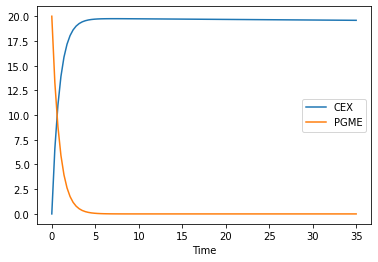

In [40]:
run_time_course(35, update_model=False)[['CEX', 'PGME']].plot();

In [41]:
get_species()[['initial_concentration']]

,initial_concentration
name,
EA,0.0000
PG,0.0000
PGME,20.0000
7-ADCA,40.0000
E CEX,0.0000
E PGME,0.0000
EA 7-ADCA,0.0000
E PG,0.0000
E 7-ADCA,0.0000


Now we are ready to fit the model, again i'm using a global method here: 

In [ ]:
run_parameter_estimation(method=PE.EVOLUTIONARY_STRATEGY_SRES, update_model=True)

In [ ]:
plots_ma = plot_per_experiment();

In [ ]:
dependent_ma = plot_per_dependent_variable()

### Continuing Analysis
As shown before, we can do further analysis again on the cluster environment, so we prepare the file just as we have done in the ODE case: 

In [ ]:
set_task_settings(T.PARAMETER_ESTIMATION, 
                  {
                      'scheduled': True,
                      'problem': {'Randomize Start Values': True},
                      'method': {'name': PE.LEVENBERG_MARQUARDT}
                  })
save_model_and_data(os.path.join(os.getcwd(), 'mass_action_master.cps'))

Now the model can be run directly with the command line version of COPASI, in cluster environments many times, and the best fit selected: 

In [ ]:
!CopasiSE --nologo --save result_file1.cps --report-file report1.txt mass_action_master.cps
!CopasiSE --nologo --save result_file2.cps --report-file report2.txt mass_action_master.cps

In [ ]:
report_fit_for_file(os.path.join(os.getcwd(), 'result_file1.cps'))

In [ ]:
report_fit_for_file(os.path.join(os.getcwd(), 'result_file2.cps'))

#### Save Images
Optionally the images obtained above can be saved. The plots returned by the `plot_per_experiment` or `plot_per_dependent_variable` function, contains an array of tuples of matplotlib figures and the corresponding axes, so that the plot can be customized later on. 

Here we just save the figures as they are to svg:

In [ ]:
def save_svgs(results, prefix):
    for i in range(len(results)):
        results[i][0].savefig(f'../svgs/{prefix}_{i}.svg')

In [ ]:
save_svgs(ode_experiment, 'exp_ode')
save_svgs(ode_dependent, 'dependent_ode')
save_svgs(plots_ma, 'exp_ma')
save_svgs(dependent_ma, 'dependent_ma')

### Loading an EnzymeML Document with kinetics
The previous examples modelled the kinetics explicitly, either via ODE's or Mass Action kinetics. This was due to the fact, that the EnzymeML document did not contain the kinetic model in the first place. Here, we do load the same EnzymeML Document, that is also used in the PySCeS case, use the same initial values and perform the optimization, using the COPASI thin layer provided with the PyEnzyme library

In [ ]:
from pyenzyme.thinlayers.TL_Copasi import ThinLayerCopasi

The Thinlayer is created by passing along an EnzymeMl document, the working directory in which to create the temporary files. And optionally a path to a file containing the parameters to vary: 

In [ ]:
tl = ThinLayerCopasi(
        path='../../PySCeS/Model_4.omex', 
        outdir='.',
        init_file='../../PySCeS/EnzymeML_Lagerman_init_copasi.yaml'
)

we can set the loaded EnzymeML document for use in basico (this is an optional step, that I take here, to change the default optimization method to Levenberg Marquardt, as it is used by PySCeS):

In [ ]:
set_current_model(tl.dm)
set_task_settings(T.PARAMETER_ESTIMATION, 
                  {
                      'scheduled': True,
                      'problem': {'Randomize Start Values': False},
                      'method': {'name': PE.LEVENBERG_MARQUARDT}
                  })

and then simply optimize: 

In [ ]:
tl.optimize()

at this point we can get an updated EnzymeML document, with the resulting parameter values: 

In [ ]:
new_doc = tl.write()

to plot the result, we simply load the the model back into basico: 

In [ ]:
plot_per_dependent_variable();

In [ ]:
plot_per_experiment();

### Upload to Dataverse

In [ ]:
publish = False
if publish:
    new_doc.uploadToDataverse(dataverse_name="enzymeml_at_work")